In [1]:
import xgboost as xgb                       #XGBoost
import optuna                               #Optuna for Hyperparameter Tuning
import sidfunc as sf                        #SidFunc - my own library for simple functions
import seaborn as sns                       #Seaborn
import pandas as pd                         #Pandas for dataframe operations
import numpy as np                          #Numpy
import matplotlib.pyplot as plt             #Matplotlib for plotting
from sklearn.model_selection import KFold   #KFold for splitting dataset
from sklearn.metrics import accuracy_score  #To check accuracy score
from warnings import filterwarnings
from factor_analyzer import FactorAnalyzer
from factor_analyzer.factor_analyzer import calculate_kmo
from scipy.stats import zscore
from sklearn.decomposition import PCA
from factor_analyzer.factor_analyzer import calculate_bartlett_sphericity
filterwarnings('ignore')
%matplotlib inline
sns.set_palette('deep')

In [2]:
#Loading Training Data
train = pd.read_csv('train.csv')

# Performing EDA

In [3]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Loan_ID            614 non-null    object 
 1   Gender             601 non-null    object 
 2   Married            611 non-null    object 
 3   Dependents         599 non-null    object 
 4   Education          614 non-null    object 
 5   Self_Employed      582 non-null    object 
 6   ApplicantIncome    614 non-null    int64  
 7   CoapplicantIncome  614 non-null    float64
 8   LoanAmount         592 non-null    float64
 9   Loan_Amount_Term   600 non-null    float64
 10  Credit_History     564 non-null    float64
 11  Property_Area      614 non-null    object 
 12  Loan_Status        614 non-null    object 
dtypes: float64(4), int64(1), object(8)
memory usage: 62.5+ KB


In [4]:
train.isna().sum()

Loan_ID               0
Gender               13
Married               3
Dependents           15
Education             0
Self_Employed        32
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount           22
Loan_Amount_Term     14
Credit_History       50
Property_Area         0
Loan_Status           0
dtype: int64

In [5]:
train.groupby('Loan_Status').median()

,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History
Loan_Status,,,,,
N,3833.5,268.0,129.0,360.0,1.0
Y,3812.5,1239.5,126.0,360.0,1.0


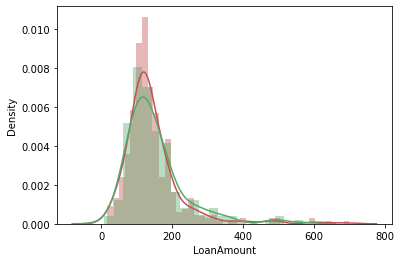

In [6]:
sns.distplot(train[train['Loan_Status']=='Y']['LoanAmount'],color='r')
sns.distplot(train[train['Loan_Status']=='N']['LoanAmount'],color='g')

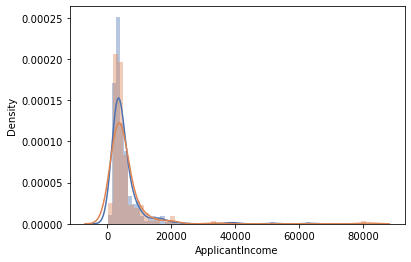

In [7]:
sns.distplot(train[train['Loan_Status']=='Y']['ApplicantIncome'])
sns.distplot(train[train['Loan_Status']=='N']['ApplicantIncome'])

In [8]:
train.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Loan_ID,614,614,LP002536,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Gender,601,2,Male,489,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Married,611,2,Yes,398,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Dependents,599,4,0,345,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Education,614,2,Graduate,480,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Self_Employed,582,2,No,500,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ApplicantIncome,614.0,NaN,NaN,NaN,5403.459283,6109.041673,150.0,2877.5,3812.5,5795.0,81000.0
CoapplicantIncome,614.0,NaN,NaN,NaN,1621.245798,2926.248369,0.0,0.0,1188.5,2297.25,41667.0
LoanAmount,592.0,NaN,NaN,NaN,146.412162,85.587325,9.0,100.0,128.0,168.0,700.0
Loan_Amount_Term,600.0,NaN,NaN,NaN,342.0,65.12041,12.0,360.0,360.0,360.0,480.0


In [9]:
#Numeric Data Study
train.select_dtypes(exclude='object').head()

,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History
0,5849,0.0,NaN,360.0,1.0
1,4583,1508.0,128.0,360.0,1.0
2,3000,0.0,66.0,360.0,1.0
3,2583,2358.0,120.0,360.0,1.0
4,6000,0.0,141.0,360.0,1.0


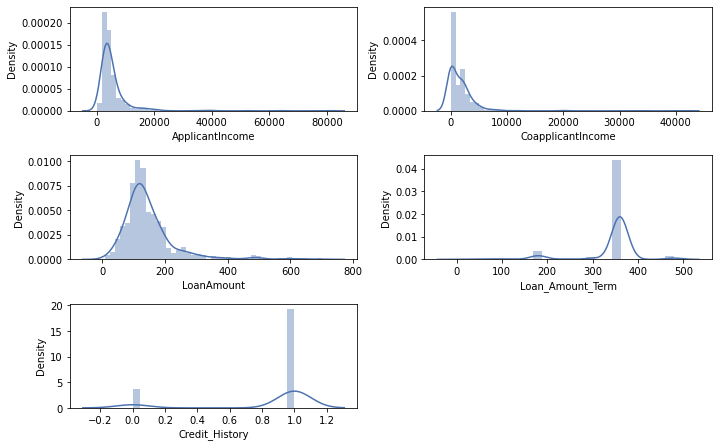

In [10]:
sf.plotmultiple(list(train.select_dtypes(exclude='object').columns),train.select_dtypes(exclude='object'),(10,10),'hist');

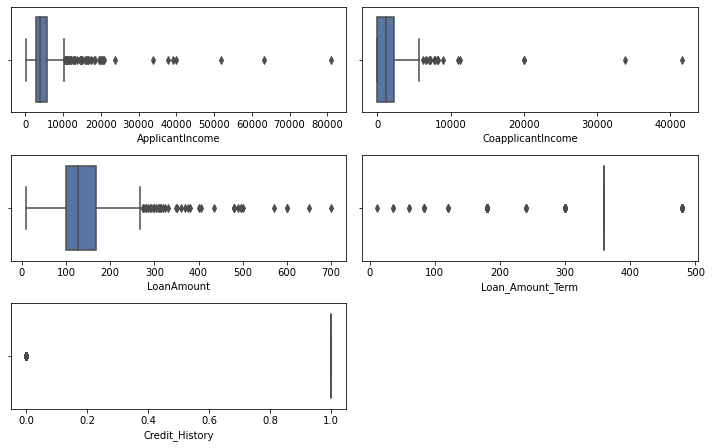

In [11]:
sf.plotmultiple(list(train.select_dtypes(exclude='object').columns),train.select_dtypes(exclude='object'),(10,10),'box');

In [12]:
#Categorical data study
train.select_dtypes('object').drop('Loan_ID',axis=1).head()

,Gender,Married,Dependents,Education,Self_Employed,Property_Area,Loan_Status
0,Male,No,0,Graduate,No,Urban,Y
1,Male,Yes,1,Graduate,No,Rural,N
2,Male,Yes,0,Graduate,Yes,Urban,Y
3,Male,Yes,0,Not Graduate,No,Urban,Y
4,Male,No,0,Graduate,No,Urban,Y


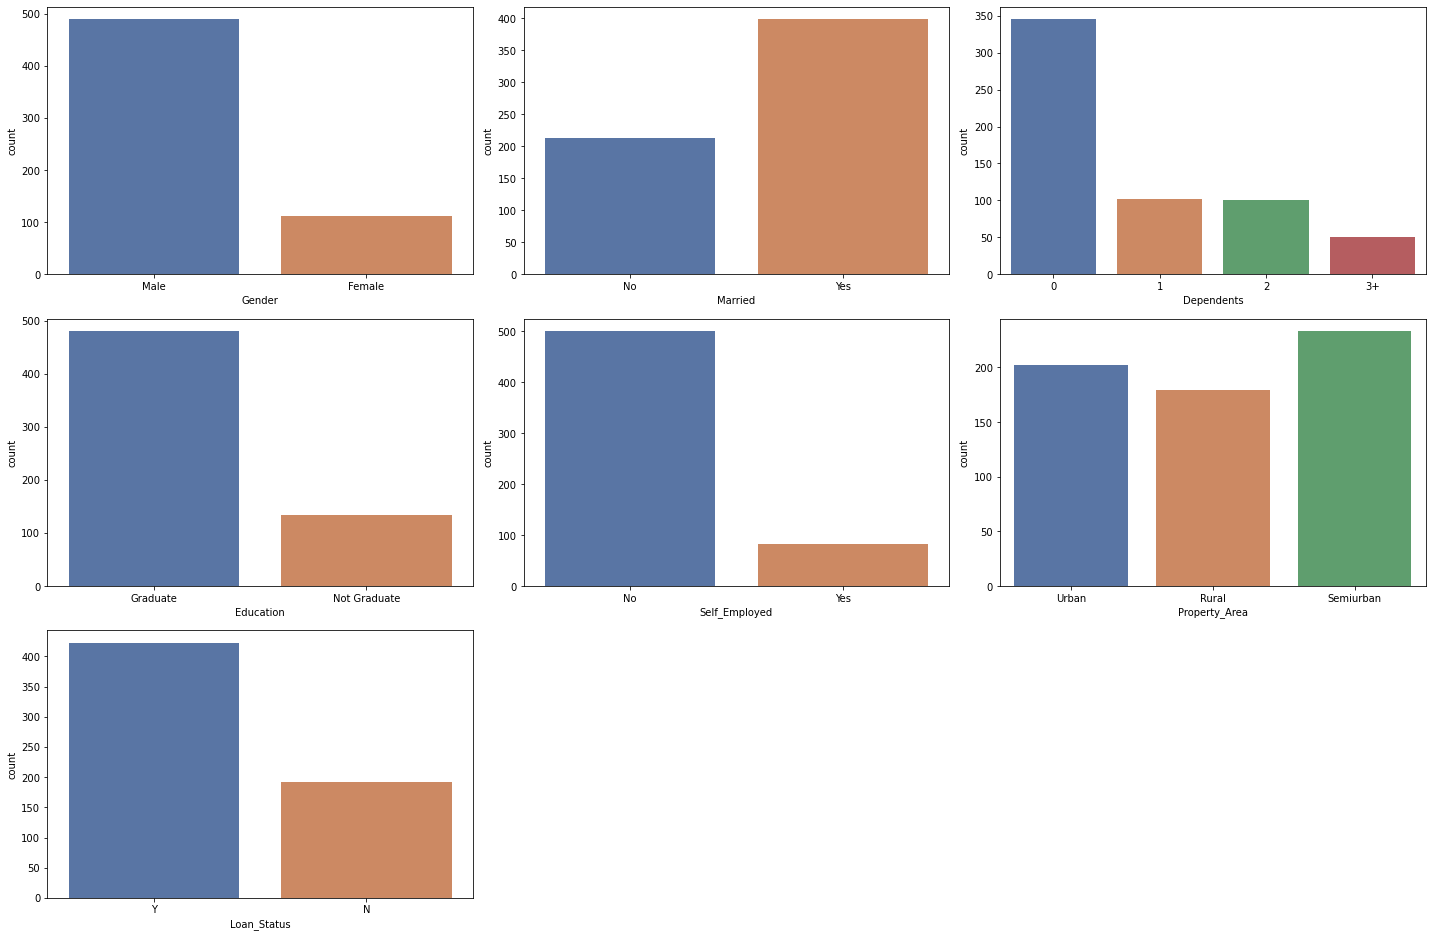

In [13]:
sf.plotmultiple(list(train.select_dtypes('object').drop('Loan_ID',axis=1).columns),train.select_dtypes('object').drop('Loan_ID',axis=1),(20,30),'count',orient='h');

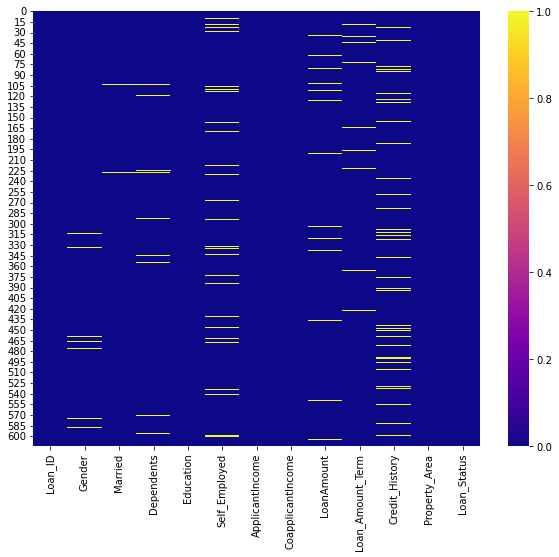

In [14]:
plt.figure(figsize=(10,8))
sns.heatmap(train.isnull(),cmap='plasma');

In [15]:
train['Loan_Status'].value_counts()

Y    422
N    192
Name: Loan_Status, dtype: int64

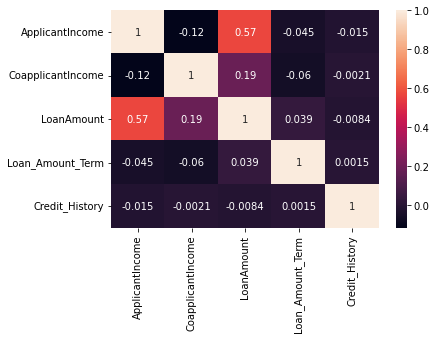

In [16]:
sns.heatmap(train.corr(),annot=True);

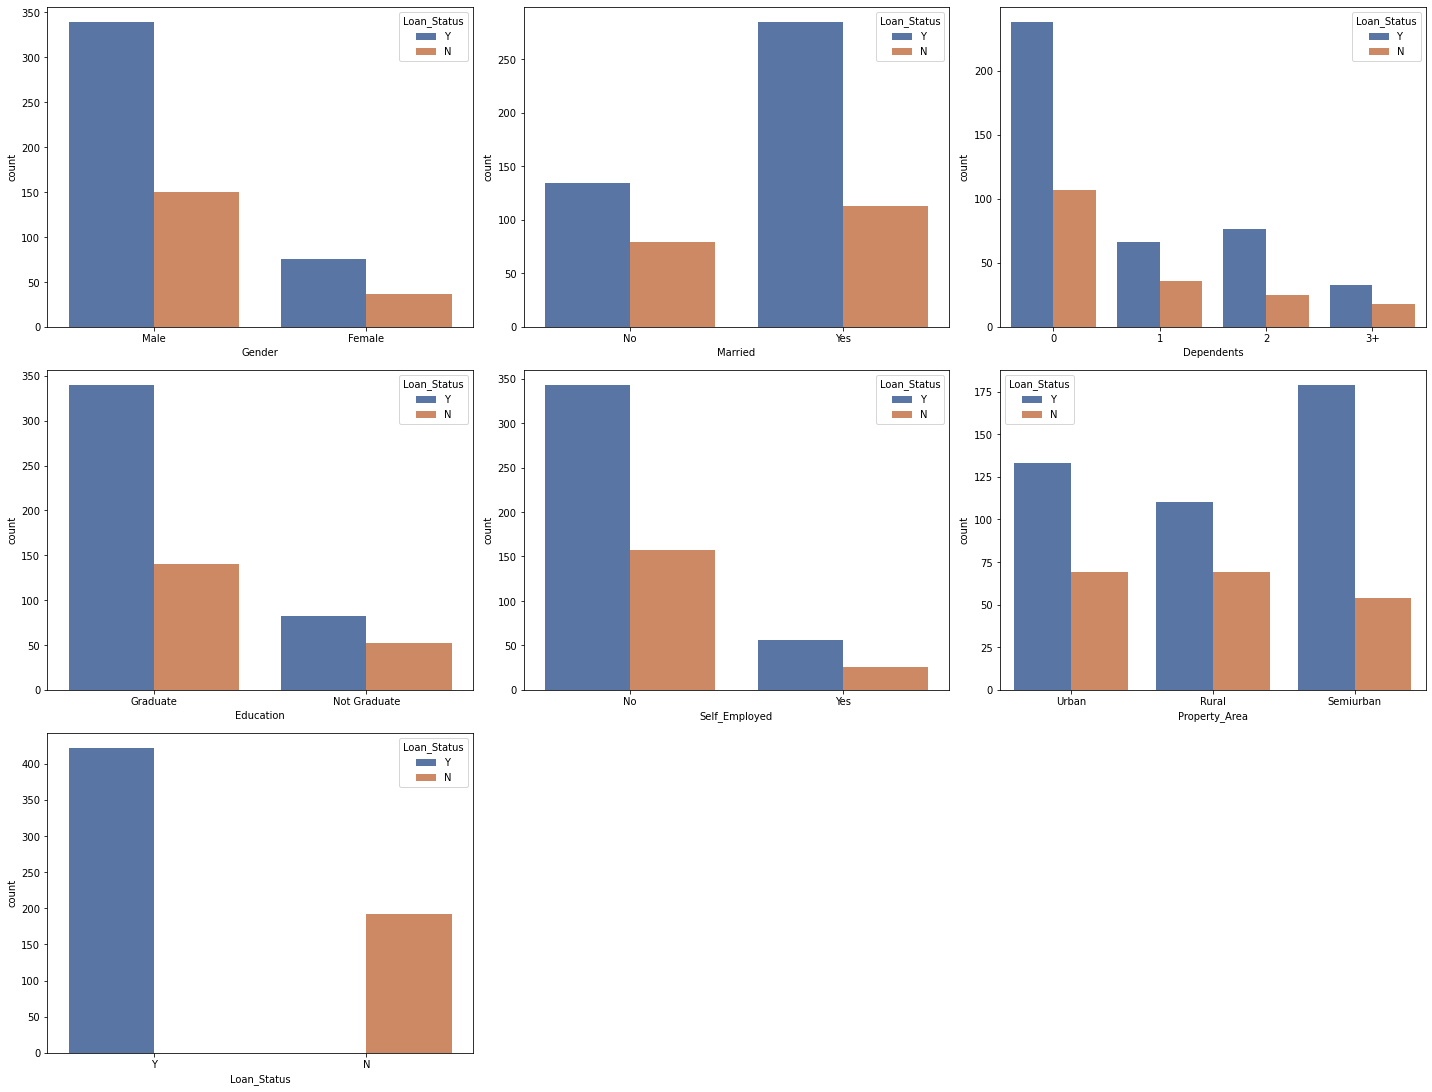

In [17]:
sf.plotmultiple(list(train.select_dtypes('object').drop('Loan_ID',axis=1).columns),train.select_dtypes('object').drop('Loan_ID',axis=1),(20,35),'count',hue='Loan_Status',orient='h')

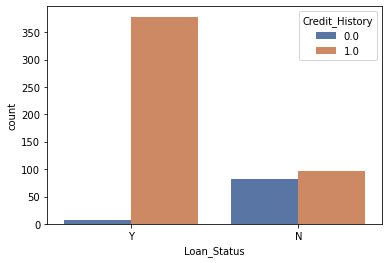

In [18]:
sns.countplot(x='Loan_Status',data=train,hue='Credit_History');

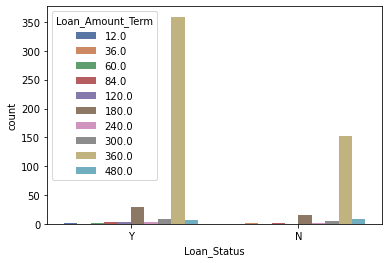

In [19]:
sns.countplot(x='Loan_Status',data=train,hue='Loan_Amount_Term');

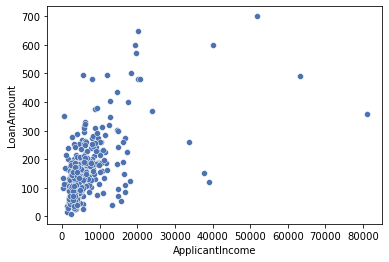

In [20]:
sns.scatterplot(train['ApplicantIncome'],train['LoanAmount']);

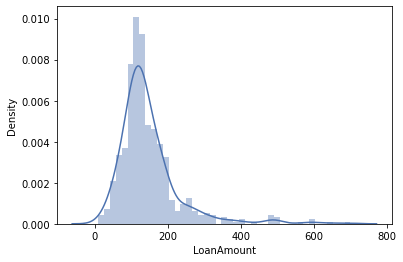

In [21]:
sns.distplot(train['LoanAmount']);

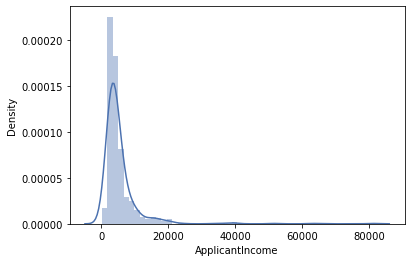

In [22]:
sns.distplot(train['ApplicantIncome']);

In [23]:
train[['LoanAmount','ApplicantIncome']].describe()

,LoanAmount,ApplicantIncome
count,592.000000,614.000000
mean,146.412162,5403.459283
std,85.587325,6109.041673
min,9.000000,150.000000
25%,100.000000,2877.500000
50%,128.000000,3812.500000
75%,168.000000,5795.000000
max,700.000000,81000.000000


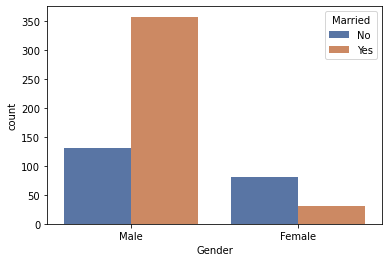

In [24]:
sns.countplot(train['Gender'],hue=train['Married']);

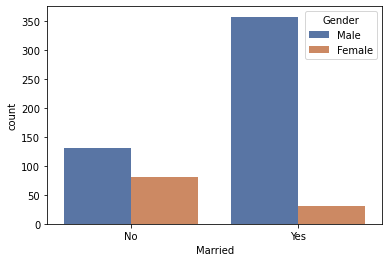

In [25]:
sns.countplot(train['Married'],hue=train['Gender']);

In [26]:
train.groupby('Self_Employed').mean()

,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History
Self_Employed,,,,,
No,5049.748000,1580.989840,141.748963,343.263804,0.835853
Yes,7380.817073,1501.341463,172.000000,336.300000,0.840000


# Processing Data:

In [27]:
def remove_outlier(col):
    Q1,Q3=col.quantile([0.20,0.90])
    IQR=Q3-Q1
    lower_range= Q1-(1.5 * IQR)
    upper_range= Q3+(1.5 * IQR)
    return lower_range, upper_range   

In [28]:
#Logic : 
#From EDA, it is seen that Loan Amount correlated to Applicant Income, 
#So Grouping Loan Amount according to Applicant Incomes, and imputing it with mean of Loan Amount in that Applicant Income group.

avgloanamount = train.groupby('ApplicantIncome').mean()['LoanAmount']
def fill_loan_amt(LoanAmount,ApplicantIncome):
    if np.isnan(LoanAmount):
        try:
            ab= avgloanamount[ApplicantIncome]
        except:
            ab=avgloanamount.mean()
    else:
        ab=LoanAmount
    return ab

In [29]:
train.groupby('Loan_Status').median()

,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History
Loan_Status,,,,,
N,3833.5,268.0,129.0,360.0,1.0
Y,3812.5,1239.5,126.0,360.0,1.0


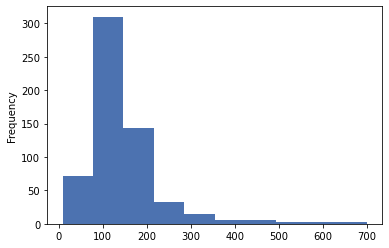

In [30]:
train['LoanAmount'].plot.hist()

In [31]:
#Logic :
#As we can see most of the loan Amount fall in range of 80-200
#Converting loan amount to categorical variable

def fill_loan_amt_cat(LoanAmount):
    a=0
    if LoanAmount<80:
        a=0
    elif LoanAmount>80 and LoanAmount<200:
        a=1
    elif LoanAmount>200 and LoanAmount<500:
        a=2
    elif LoanAmount>500:
        a=3
    return a

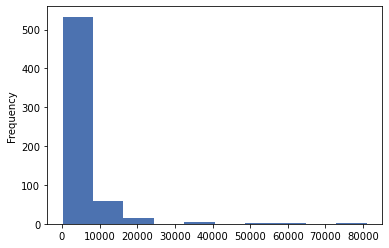

In [32]:
train['ApplicantIncome'].plot.hist()

In [33]:
#Logic :
#As we can see most of the Applicant Income fall in range of 0-20000
#Converting loan amount to categorical variable

def fill_applicantincome_cat(ApplicantIncome):
    a=0
    if ApplicantIncome<5000:
        a=0
    elif ApplicantIncome>5000 and ApplicantIncome<10000:
        a=1
    elif ApplicantIncome>10000 and ApplicantIncome<20000:
        a=2
    elif ApplicantIncome>20000:
        a=3
    return a

In [34]:
#Logic :
#As we can see from EDA, Mode of Male being married is comparitively very high.

def fill_gender(Gender,Married):
    if np.isnan(Gender):
        if Married ==1:
            return (1)
        else:
            return (0)
    else:
        return Gender

In [35]:
#Logic :
#As we can see from EDA, Mode of Male being married is comparitively very high.

def fill_married(Married,Gender):
    if np.isnan(Married):
        if Gender ==0:
            return (1)
        else:
            return (0)
    else:
        return Married

In [36]:
#Logic :
#As we can see from EDA, Treating Self_Employe in accordance with Applicant Income.

def fill_se(Self_Employed,ApplicantIncome):
    if np.isnan(Self_Employed):
        if ApplicantIncome > 7200:
            return (1)
        else:
            return (0)
    else:
        return Self_Employed

In [37]:
#Logic :
#As we can see from EDA, If Co-applicant Income present then 1 else 0.

def fill_CoapplicantIncome(CoapplicantIncome):
    if CoapplicantIncome ==0:
         return (1)
    else:
        return (0)

In [46]:
#Declaring Function to Process Data
def processdata(df,train=True):
    
    if train==True:
        df = df[df['ApplicantIncome'] < 50000] #Since most of the points fall withing 50,000
        df = df[df['LoanAmount'] < 500] #Since most of the points fall withing 500
    
    df['Gender']=df['Gender'].replace(to_replace='Male',value=0)
    df['Gender']=df['Gender'].replace(to_replace='Female',value=1)
    df['Married']=df['Married'].replace(to_replace='No',value=0)
    df['Married']=df['Married'].replace(to_replace='Yes',value=1)
    df['Education']=df['Education'].replace(to_replace='Not Graduate',value=0)
    df['Education']=df['Education'].replace(to_replace='Graduate',value=1)
    df['Self_Employed']=df['Self_Employed'].replace(to_replace='No',value=0)
    df['Self_Employed']=df['Self_Employed'].replace(to_replace='Yes',value=1)
    df['Property_Area']=df['Property_Area'].replace(to_replace='Semiurban',value=0)
    df['Property_Area']=df['Property_Area'].replace(to_replace='Urban',value=1)
    df['Property_Area']=df['Property_Area'].replace(to_replace='Rural',value=2)
    df['Loan_Amount_Term']=df['Loan_Amount_Term'].replace(to_replace=360.0,value=1)
    df['Loan_Amount_Term']=df['Loan_Amount_Term'].replace(to_replace=180.0,value=0)
    df['Loan_Amount_Term']=df['Loan_Amount_Term'].replace(to_replace=480.0,value=0)
    df['Loan_Amount_Term']=df['Loan_Amount_Term'].replace(to_replace=300.0,value=0)
    df['Loan_Amount_Term']=df['Loan_Amount_Term'].replace(to_replace=84.0,value=0)
    df['Loan_Amount_Term']=df['Loan_Amount_Term'].replace(to_replace=240.0,value=0)
    df['Loan_Amount_Term']=df['Loan_Amount_Term'].replace(to_replace=120.0,value=0)
    df['Loan_Amount_Term']=df['Loan_Amount_Term'].replace(to_replace=36.0,value=0)
    df['Loan_Amount_Term']=df['Loan_Amount_Term'].replace(to_replace=60.0,value=0)
    df['Loan_Amount_Term']=df['Loan_Amount_Term'].replace(to_replace=12.0,value=0)
    df['Dependents']=df['Dependents'].replace(to_replace='3+',value='3')
    
    #Missing_Values_Treatment
    df['Married'] = df.apply(lambda x: fill_gender(x['Married'], x['Gender']), axis=1)
    df['Gender'] = df.apply(lambda x: fill_gender(x['Gender'], x['Married']), axis=1)
    df['LoanAmount'] = df.apply(lambda x: fill_loan_amt(x['LoanAmount'], x['ApplicantIncome']), axis=1)
    df['LoanAmount'] = df['LoanAmount'].fillna(136.9586777)
    #df['CoapplicantIncome'] = df.apply(lambda x: fill_CoapplicantIncome(x['CoapplicantIncome']), axis=1)
    df['Dependents'] = df['Dependents'].fillna(1)
    df['Self_Employed'] = df.apply(lambda x: fill_se(x['Self_Employed'], x['ApplicantIncome']), axis=1)
    df['Loan_Amount_Term'] = df['Loan_Amount_Term'].fillna(0)
    df['Credit_History'] = df['Credit_History'].fillna(-999)
    #df['LoanAmount'] = df.apply(lambda x: fill_loan_amt_cat(x['LoanAmount']), axis=1)
    #df['ApplicantIncome'] = df.apply(lambda x: fill_applicantincome_cat(x['ApplicantIncome']), axis=1)
    #Outlier Treatment
    for i in ['LoanAmount','CoapplicantIncome','ApplicantIncome']:
        LL, UL = remove_outlier(df[i])
        df[i] = np.where(df[i] > UL, UL, df[i])
        df[i] = np.where(df[i] < LL, LL, df[i])
    return df

In [47]:
#Processing Training Data
train=processdata(train.iloc[0:500,:],train=True)
train.reset_index(inplace=True,drop=True)

In [48]:
train.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001003,0.0,1.0,1,1,0.0,4583.0,1508.0,128.0,1.0,1.0,2,N
1,LP001005,0.0,1.0,0,1,1.0,3000.0,0.0,66.0,1.0,1.0,1,Y
2,LP001006,0.0,1.0,0,0,0.0,2583.0,2358.0,120.0,1.0,1.0,1,Y
3,LP001008,0.0,0.0,0,1,0.0,6000.0,0.0,141.0,1.0,1.0,1,Y
4,LP001011,0.0,1.0,2,1,1.0,5417.0,4196.0,267.0,1.0,1.0,1,Y


In [49]:
train.isna().sum()

Loan_ID              0
Gender               0
Married              0
Dependents           0
Education            0
Self_Employed        0
ApplicantIncome      0
CoapplicantIncome    0
LoanAmount           0
Loan_Amount_Term     0
Credit_History       0
Property_Area        0
Loan_Status          0
dtype: int64

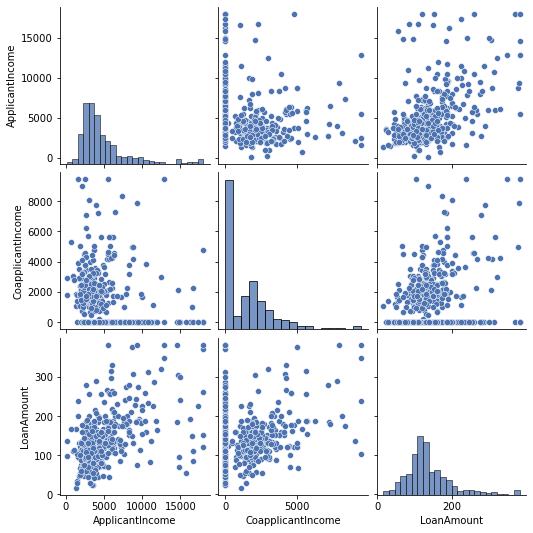

In [50]:
sns.pairplot(train[['ApplicantIncome','CoapplicantIncome','LoanAmount']])

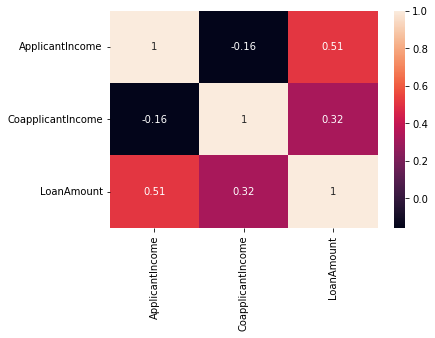

In [51]:
sns.heatmap(train[['ApplicantIncome','CoapplicantIncome','LoanAmount']].corr(),annot=True)

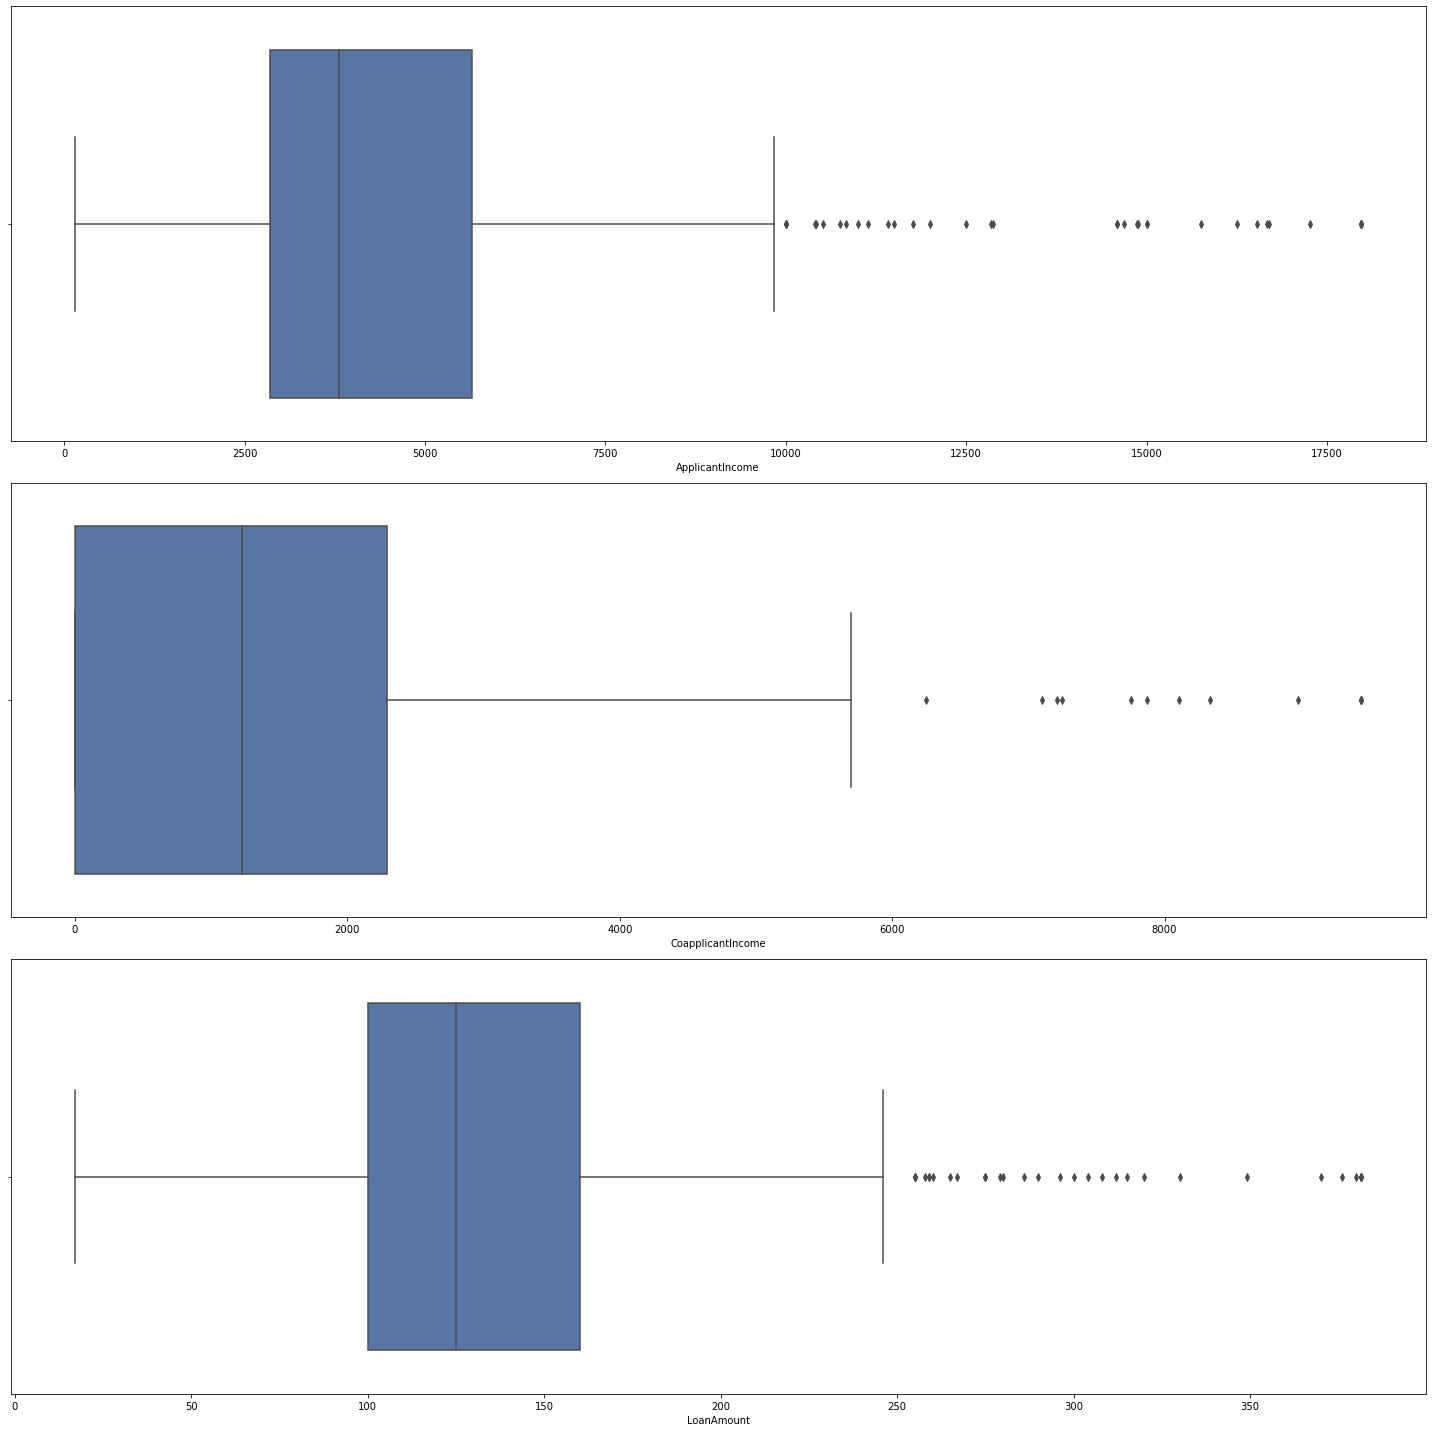

In [54]:
sf.plotmultiple(['ApplicantIncome','CoapplicantIncome','LoanAmount'],train,(20,20),'box')

In [52]:
chi_square_value,p_value=calculate_bartlett_sphericity(train[['ApplicantIncome','CoapplicantIncome','LoanAmount']])
p_value

3.611753248187767e-61

In [53]:
kmo_all,kmo_model=calculate_kmo(train[['ApplicantIncome','CoapplicantIncome','LoanAmount']])
kmo_model

0.34201847964223564

In [55]:
df_num_scaled_TRAIN=train[['ApplicantIncome','CoapplicantIncome','LoanAmount']].apply(zscore)

In [56]:
# NOTE - we are generating only 8 PCA dimensions (dimensionality reduction from 33 to 8)
pca_TRAIN = PCA(n_components=3, random_state=123)
df_pca_TRAIN = pca_TRAIN.fit_transform(df_num_scaled_TRAIN)
df_pca_TRAIN.transpose() # Component output

array([[-0.15403502, -1.41264744, -0.51933895, ..., -0.15896596,
        -1.08757726,  1.55031925],
       [ 0.02444415, -0.55550052,  0.71961212, ...,  0.61258655,
        -0.48013178,  1.27754863],
       [ 0.06112663,  0.05439028, -0.0199769 , ...,  0.58171978,
        -0.27442387,  0.23133468]])

In [57]:
pca_TRAIN.components_

array([[ 0.62219974,  0.25737395,  0.73934169],
       [-0.50324367,  0.85492401,  0.12589972],
       [ 0.59967766,  0.4504038 , -0.66145531]])

In [58]:
pca_TRAIN.explained_variance_ratio_

array([0.5149769 , 0.38033157, 0.10469153])

In [59]:
df_pca_TRAIN = pd.DataFrame(df_pca_TRAIN,columns=['ApplicantIncome','CoapplicantIncome','LoanAmount'])
df_pca_TRAIN.head()

,ApplicantIncome,CoapplicantIncome,LoanAmount
0,-0.154035,0.024444,0.061127
1,-1.412647,-0.555501,0.054390
2,-0.519339,0.719612,-0.019977
3,0.064944,-0.875709,-0.182152
4,2.041859,1.428958,-0.603442


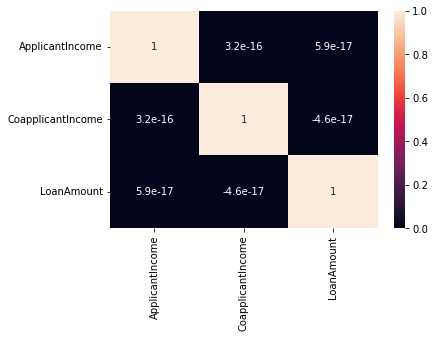

In [93]:
#Treated multicollinearity
sns.heatmap(df_pca_TRAIN.corr(),annot=True)

In [60]:
df_train = pd.concat([train.drop(['ApplicantIncome','CoapplicantIncome','LoanAmount'],axis=1), df_pca_TRAIN], axis=1)

# Model Building

In [61]:
#Dividing into Dependent and Independent variables
X_train = df_train.drop(['Loan_Status','Loan_ID'],axis=1)
y_train = df_train['Loan_Status']

In [62]:
#Declaring Optuna Objective function for hyperparameter tuning.
def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 350, 1000),
        'max_depth': trial.suggest_int('max_depth', 6, 13),
        'learning_rate': trial.suggest_uniform('learning_rate', 0.009, 0.10),
        'subsample': trial.suggest_uniform('subsample', 0.50, 1),
        'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.50, 1),
        'gamma': trial.suggest_int('gamma', 0, 0.05),
        'missing': -999,
       }
        
    clf = xgb.XGBClassifier(**params) #Using XGBoost Classifier
    auccuracies = []
    auccuracies2= []
    X_train_k = X_train.values
    y_train_k = y_train.values
    kf = KFold(n_splits=3,random_state=2000,shuffle=True)
    for train_idx, valid_idx in kf.split(X_train_k,y_train_k):
        clf.fit(X_train_k[train_idx, :], y_train_k[train_idx])
        pred = clf.predict(X_train_k[valid_idx, :])
        accuracy = accuracy_score(y_train_k[valid_idx],pred)
        auccuracies.append(accuracy)
    print(f'Trial done: Accuracy values on folds: {auccuracies}')
    return np.average(auccuracies)

In [63]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100)
print("Number of finished trials: {}".format(len(study.trials)))
print("Best trial:")
trial = study.best_trial
print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

[I 2021-10-04 16:37:27,220] A new study created in memory with name: no-name-89ed8b67-c0ab-49c8-a472-be62a74433ff


[16:37:27] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:37:27] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:37:28] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-10-04 16:37:29,245] Trial 0 finished with value: 0.7747790780988776 and parameters: {'n_estimators': 758, 'max_depth': 13, 'learning_rate': 0.09199304594680212, 'subsample': 0.812010761373025, 'colsample_bytree': 0.8888873406120703, 'gamma': 0}. Best is trial 0 with value: 0.7747790780988776.


Trial done: Accuracy values on folds: [0.7547169811320755, 0.7911392405063291, 0.7784810126582279]
[16:37:29] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:37:29] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:37:30] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like 

[I 2021-10-04 16:37:30,662] Trial 1 finished with value: 0.7895204734230289 and parameters: {'n_estimators': 425, 'max_depth': 9, 'learning_rate': 0.023348125787199685, 'subsample': 0.675435581187674, 'colsample_bytree': 0.5665749091159841, 'gamma': 0}. Best is trial 1 with value: 0.7895204734230289.


Trial done: Accuracy values on folds: [0.7672955974842768, 0.7974683544303798, 0.8037974683544303]
[16:37:30] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:37:31] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:37:31] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like 

[I 2021-10-04 16:37:32,091] Trial 2 finished with value: 0.781081654857628 and parameters: {'n_estimators': 415, 'max_depth': 8, 'learning_rate': 0.057494747551691545, 'subsample': 0.9251085844166633, 'colsample_bytree': 0.6653052469813643, 'gamma': 0}. Best is trial 1 with value: 0.7895204734230289.


Trial done: Accuracy values on folds: [0.7672955974842768, 0.7784810126582279, 0.7974683544303798]
[16:37:32] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:37:32] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:37:33] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like 

[I 2021-10-04 16:37:34,722] Trial 3 finished with value: 0.7895204734230289 and parameters: {'n_estimators': 942, 'max_depth': 11, 'learning_rate': 0.02409179082363148, 'subsample': 0.6913995949085825, 'colsample_bytree': 0.5637759384333988, 'gamma': 0}. Best is trial 1 with value: 0.7895204734230289.


Trial done: Accuracy values on folds: [0.7672955974842768, 0.7911392405063291, 0.810126582278481]
[16:37:34] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:37:35] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:37:36] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like t

[I 2021-10-04 16:37:37,102] Trial 4 finished with value: 0.7684765013401268 and parameters: {'n_estimators': 706, 'max_depth': 10, 'learning_rate': 0.024107319815394716, 'subsample': 0.9999680891432936, 'colsample_bytree': 0.917238662470729, 'gamma': 0}. Best is trial 1 with value: 0.7895204734230289.


Trial done: Accuracy values on folds: [0.7421383647798742, 0.7784810126582279, 0.7848101265822784]
[16:37:37] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:37:37] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:37:38] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like 

[I 2021-10-04 16:37:39,131] Trial 5 finished with value: 0.7789852187989279 and parameters: {'n_estimators': 649, 'max_depth': 13, 'learning_rate': 0.029986907245542788, 'subsample': 0.8625711237890388, 'colsample_bytree': 0.519146246703776, 'gamma': 0}. Best is trial 1 with value: 0.7895204734230289.


Trial done: Accuracy values on folds: [0.7610062893081762, 0.7658227848101266, 0.810126582278481]
[16:37:39] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:37:39] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:37:40] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like t

[I 2021-10-04 16:37:41,159] Trial 6 finished with value: 0.768436695592177 and parameters: {'n_estimators': 807, 'max_depth': 10, 'learning_rate': 0.06531827913652433, 'subsample': 0.8287625312671849, 'colsample_bytree': 0.5696237170674159, 'gamma': 0}. Best is trial 1 with value: 0.7895204734230289.


Trial done: Accuracy values on folds: [0.7610062893081762, 0.7658227848101266, 0.7784810126582279]
[16:37:41] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:37:41] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:37:42] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like 

[I 2021-10-04 16:37:43,454] Trial 7 finished with value: 0.7747392723509275 and parameters: {'n_estimators': 951, 'max_depth': 6, 'learning_rate': 0.08436197163228956, 'subsample': 0.930231576475864, 'colsample_bytree': 0.659504094812491, 'gamma': 0}. Best is trial 1 with value: 0.7895204734230289.


Trial done: Accuracy values on folds: [0.7735849056603774, 0.7784810126582279, 0.7721518987341772]
[16:37:43] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:37:44] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:37:44] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like 

[I 2021-10-04 16:37:45,220] Trial 8 finished with value: 0.7705596688161771 and parameters: {'n_estimators': 691, 'max_depth': 9, 'learning_rate': 0.09138682041725256, 'subsample': 0.519798470255141, 'colsample_bytree': 0.9546911835213074, 'gamma': 0}. Best is trial 1 with value: 0.7895204734230289.


Trial done: Accuracy values on folds: [0.7547169811320755, 0.7911392405063291, 0.7658227848101266]
[16:37:45] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:37:45] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:37:46] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like 

[I 2021-10-04 16:37:47,327] Trial 9 finished with value: 0.7852877955576786 and parameters: {'n_estimators': 681, 'max_depth': 9, 'learning_rate': 0.01900984350442344, 'subsample': 0.5777581273887848, 'colsample_bytree': 0.574124593982553, 'gamma': 0}. Best is trial 1 with value: 0.7895204734230289.


Trial done: Accuracy values on folds: [0.7735849056603774, 0.7784810126582279, 0.8037974683544303]
[16:37:47] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:37:47] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:37:48] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like 

[I 2021-10-04 16:37:48,570] Trial 10 finished with value: 0.7832046280816284 and parameters: {'n_estimators': 352, 'max_depth': 6, 'learning_rate': 0.04192968325491654, 'subsample': 0.6996678806634384, 'colsample_bytree': 0.8068035393624904, 'gamma': 0}. Best is trial 1 with value: 0.7895204734230289.


Trial done: Accuracy values on folds: [0.7610062893081762, 0.7784810126582279, 0.810126582278481]
[16:37:48] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:37:49] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:37:49] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like t

[I 2021-10-04 16:37:50,519] Trial 11 finished with value: 0.7916169094817292 and parameters: {'n_estimators': 519, 'max_depth': 12, 'learning_rate': 0.01292387848535922, 'subsample': 0.6777222562632009, 'colsample_bytree': 0.6777798694929549, 'gamma': 0}. Best is trial 11 with value: 0.7916169094817292.


Trial done: Accuracy values on folds: [0.7735849056603774, 0.7974683544303798, 0.8037974683544303]
[16:37:50] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:37:51] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:37:51] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like 

[I 2021-10-04 16:37:52,460] Trial 12 finished with value: 0.7853010641403285 and parameters: {'n_estimators': 505, 'max_depth': 12, 'learning_rate': 0.012698349599742703, 'subsample': 0.630021443523614, 'colsample_bytree': 0.6968876827632183, 'gamma': 0}. Best is trial 11 with value: 0.7916169094817292.


Trial done: Accuracy values on folds: [0.7672955974842768, 0.7911392405063291, 0.7974683544303798]
[16:37:52] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:37:53] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:37:53] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like 

[I 2021-10-04 16:37:54,109] Trial 13 finished with value: 0.7873975001990288 and parameters: {'n_estimators': 543, 'max_depth': 8, 'learning_rate': 0.037870555000220386, 'subsample': 0.7367098072057271, 'colsample_bytree': 0.7745667477604175, 'gamma': 0}. Best is trial 11 with value: 0.7916169094817292.


Trial done: Accuracy values on folds: [0.7735849056603774, 0.7911392405063291, 0.7974683544303798]
[16:37:54] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:37:54] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:37:55] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like 

[I 2021-10-04 16:37:55,797] Trial 14 finished with value: 0.7873975001990288 and parameters: {'n_estimators': 488, 'max_depth': 11, 'learning_rate': 0.009277983418034296, 'subsample': 0.6169585306662587, 'colsample_bytree': 0.6299330531382522, 'gamma': 0}. Best is trial 11 with value: 0.7916169094817292.


Trial done: Accuracy values on folds: [0.7735849056603774, 0.7911392405063291, 0.7974683544303798]
[16:37:55] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:37:56] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:37:57] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like 

[I 2021-10-04 16:37:57,606] Trial 15 finished with value: 0.7769153199055276 and parameters: {'n_estimators': 574, 'max_depth': 8, 'learning_rate': 0.04466459992921594, 'subsample': 0.6651659549922224, 'colsample_bytree': 0.742330706081336, 'gamma': 0}. Best is trial 11 with value: 0.7916169094817292.


Trial done: Accuracy values on folds: [0.7421383647798742, 0.7911392405063291, 0.7974683544303798]
[16:37:57] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:37:58] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:37:58] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like 

[I 2021-10-04 16:37:59,085] Trial 16 finished with value: 0.7789852187989279 and parameters: {'n_estimators': 449, 'max_depth': 11, 'learning_rate': 0.07228199240314212, 'subsample': 0.7624406017630183, 'colsample_bytree': 0.5050340428505944, 'gamma': 0}. Best is trial 11 with value: 0.7916169094817292.


Trial done: Accuracy values on folds: [0.7610062893081762, 0.7848101265822784, 0.7911392405063291]
[16:37:59] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:37:59] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:37:59] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like 

[I 2021-10-04 16:38:00,372] Trial 17 finished with value: 0.7916301780643792 and parameters: {'n_estimators': 354, 'max_depth': 12, 'learning_rate': 0.032471958148778776, 'subsample': 0.5354909664916038, 'colsample_bytree': 0.8360538111920195, 'gamma': 0}. Best is trial 17 with value: 0.7916301780643792.


Trial done: Accuracy values on folds: [0.7672955974842768, 0.8037974683544303, 0.8037974683544303]
[16:38:00] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:38:00] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:38:01] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like 

[I 2021-10-04 16:38:01,517] Trial 18 finished with value: 0.7789984873815778 and parameters: {'n_estimators': 352, 'max_depth': 12, 'learning_rate': 0.03368486632405473, 'subsample': 0.5124416942176485, 'colsample_bytree': 0.8435127964851163, 'gamma': 0}. Best is trial 17 with value: 0.7916301780643792.


Trial done: Accuracy values on folds: [0.7547169811320755, 0.7784810126582279, 0.8037974683544303]
[16:38:01] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:38:02] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:38:02] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like 

[I 2021-10-04 16:38:03,246] Trial 19 finished with value: 0.7895204734230289 and parameters: {'n_estimators': 596, 'max_depth': 12, 'learning_rate': 0.04735515602468389, 'subsample': 0.5700806365134894, 'colsample_bytree': 0.7303482014223934, 'gamma': 0}. Best is trial 17 with value: 0.7916301780643792.


Trial done: Accuracy values on folds: [0.7672955974842768, 0.8037974683544303, 0.7974683544303798]
[16:38:03] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:38:03] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:38:04] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like 

[I 2021-10-04 16:38:04,545] Trial 20 finished with value: 0.7832311652469283 and parameters: {'n_estimators': 408, 'max_depth': 13, 'learning_rate': 0.052380283391286114, 'subsample': 0.5701151815908185, 'colsample_bytree': 0.9967416626298176, 'gamma': 0}. Best is trial 17 with value: 0.7916301780643792.


Trial done: Accuracy values on folds: [0.7484276729559748, 0.8037974683544303, 0.7974683544303798]
[16:38:04] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:38:05] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:38:05] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like 

[I 2021-10-04 16:38:06,523] Trial 21 finished with value: 0.7831648223336783 and parameters: {'n_estimators': 445, 'max_depth': 10, 'learning_rate': 0.019927190553917024, 'subsample': 0.7513759997870196, 'colsample_bytree': 0.6161618938102796, 'gamma': 0}. Best is trial 17 with value: 0.7916301780643792.


Trial done: Accuracy values on folds: [0.779874213836478, 0.7784810126582279, 0.7911392405063291]
[16:38:06] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:38:07] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:38:07] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like t

[I 2021-10-04 16:38:08,323] Trial 22 finished with value: 0.7769020513228776 and parameters: {'n_estimators': 506, 'max_depth': 7, 'learning_rate': 0.03105845136912585, 'subsample': 0.6466365544004904, 'colsample_bytree': 0.8394046895241517, 'gamma': 0}. Best is trial 17 with value: 0.7916301780643792.


Trial done: Accuracy values on folds: [0.7484276729559748, 0.7848101265822784, 0.7974683544303798]
[16:38:08] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:38:09] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:38:10] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like 

[I 2021-10-04 16:38:11,237] Trial 23 finished with value: 0.7874240373643288 and parameters: {'n_estimators': 958, 'max_depth': 11, 'learning_rate': 0.013629825011797964, 'subsample': 0.7028383780991747, 'colsample_bytree': 0.7870107695207973, 'gamma': 0}. Best is trial 17 with value: 0.7916301780643792.


Trial done: Accuracy values on folds: [0.7610062893081762, 0.7911392405063291, 0.810126582278481]
[16:38:11] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:38:11] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:38:12] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like t

[I 2021-10-04 16:38:12,573] Trial 24 finished with value: 0.7873975001990288 and parameters: {'n_estimators': 390, 'max_depth': 12, 'learning_rate': 0.025085477503316564, 'subsample': 0.604837294013306, 'colsample_bytree': 0.7086824071358054, 'gamma': 0}. Best is trial 17 with value: 0.7916301780643792.


Trial done: Accuracy values on folds: [0.7735849056603774, 0.7848101265822784, 0.8037974683544303]
[16:38:12] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:38:13] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:38:13] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like 

[I 2021-10-04 16:38:14,261] Trial 25 finished with value: 0.7873975001990288 and parameters: {'n_estimators': 474, 'max_depth': 9, 'learning_rate': 0.016239313901943258, 'subsample': 0.786919788573656, 'colsample_bytree': 0.6093771087133765, 'gamma': 0}. Best is trial 17 with value: 0.7916301780643792.


Trial done: Accuracy values on folds: [0.7735849056603774, 0.7848101265822784, 0.8037974683544303]
[16:38:14] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:38:14] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:38:15] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like 

[I 2021-10-04 16:38:15,957] Trial 26 finished with value: 0.7810949234402781 and parameters: {'n_estimators': 599, 'max_depth': 10, 'learning_rate': 0.03563508751301278, 'subsample': 0.5326288824493929, 'colsample_bytree': 0.8553630330004557, 'gamma': 0}. Best is trial 17 with value: 0.7916301780643792.


Trial done: Accuracy values on folds: [0.7610062893081762, 0.7848101265822784, 0.7974683544303798]
[16:38:16] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:38:16] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:38:17] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like 

[I 2021-10-04 16:38:17,686] Trial 27 finished with value: 0.7810949234402781 and parameters: {'n_estimators': 549, 'max_depth': 12, 'learning_rate': 0.026507423757643242, 'subsample': 0.6704615391411374, 'colsample_bytree': 0.6733623499694913, 'gamma': 0}. Best is trial 17 with value: 0.7916301780643792.


Trial done: Accuracy values on folds: [0.7610062893081762, 0.7721518987341772, 0.810126582278481]
[16:38:17] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:38:18] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:38:18] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like t

[I 2021-10-04 16:38:19,103] Trial 28 finished with value: 0.789507204840379 and parameters: {'n_estimators': 396, 'max_depth': 11, 'learning_rate': 0.018221751591194046, 'subsample': 0.7152314592712408, 'colsample_bytree': 0.5363881131232026, 'gamma': 0}. Best is trial 17 with value: 0.7916301780643792.


Trial done: Accuracy values on folds: [0.7735849056603774, 0.7911392405063291, 0.8037974683544303]
[16:38:19] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:38:20] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:38:20] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like 

[I 2021-10-04 16:38:21,913] Trial 29 finished with value: 0.7789852187989279 and parameters: {'n_estimators': 800, 'max_depth': 13, 'learning_rate': 0.010095512991261286, 'subsample': 0.8163461137568478, 'colsample_bytree': 0.8680286325372525, 'gamma': 0}. Best is trial 17 with value: 0.7916301780643792.


Trial done: Accuracy values on folds: [0.7610062893081762, 0.759493670886076, 0.8164556962025317]
[16:38:21] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:38:22] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:38:23] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like t

[I 2021-10-04 16:38:23,623] Trial 30 finished with value: 0.7895337420056788 and parameters: {'n_estimators': 626, 'max_depth': 13, 'learning_rate': 0.041878334077949456, 'subsample': 0.5587302005752779, 'colsample_bytree': 0.7382684911586244, 'gamma': 0}. Best is trial 17 with value: 0.7916301780643792.


Trial done: Accuracy values on folds: [0.7610062893081762, 0.8037974683544303, 0.8037974683544303]
[16:38:23] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:38:24] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:38:25] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like 

[I 2021-10-04 16:38:25,852] Trial 31 finished with value: 0.7811479977708782 and parameters: {'n_estimators': 882, 'max_depth': 13, 'learning_rate': 0.03919494999424405, 'subsample': 0.5494442793351151, 'colsample_bytree': 0.7650341922376512, 'gamma': 0}. Best is trial 17 with value: 0.7916301780643792.


Trial done: Accuracy values on folds: [0.7358490566037735, 0.8164556962025317, 0.7911392405063291]
[16:38:25] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:38:26] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:38:26] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like 

[I 2021-10-04 16:38:27,489] Trial 32 finished with value: 0.7684632327574769 and parameters: {'n_estimators': 635, 'max_depth': 13, 'learning_rate': 0.049380028011684084, 'subsample': 0.5016293586449115, 'colsample_bytree': 0.8051984061834379, 'gamma': 0}. Best is trial 17 with value: 0.7916301780643792.


Trial done: Accuracy values on folds: [0.7484276729559748, 0.7784810126582279, 0.7784810126582279]
[16:38:27] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:38:27] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:38:28] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like 

[I 2021-10-04 16:38:28,815] Trial 33 finished with value: 0.7832444338295783 and parameters: {'n_estimators': 444, 'max_depth': 12, 'learning_rate': 0.057971515817517576, 'subsample': 0.5945596074823342, 'colsample_bytree': 0.9068301538150202, 'gamma': 0}. Best is trial 17 with value: 0.7916301780643792.


Trial done: Accuracy values on folds: [0.7421383647798742, 0.8227848101265823, 0.7848101265822784]
[16:38:28] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:38:29] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:38:29] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like 

[I 2021-10-04 16:38:30,412] Trial 34 finished with value: 0.7832046280816284 and parameters: {'n_estimators': 532, 'max_depth': 7, 'learning_rate': 0.029948459939026395, 'subsample': 0.6423365869669128, 'colsample_bytree': 0.6432436706046061, 'gamma': 0}. Best is trial 17 with value: 0.7916301780643792.


Trial done: Accuracy values on folds: [0.7610062893081762, 0.7784810126582279, 0.810126582278481]
[16:38:30] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:38:31] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:38:31] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like t

[I 2021-10-04 16:38:32,449] Trial 35 finished with value: 0.7832046280816284 and parameters: {'n_estimators': 734, 'max_depth': 13, 'learning_rate': 0.02403748231127694, 'subsample': 0.546970790383481, 'colsample_bytree': 0.6968675850956955, 'gamma': 0}. Best is trial 17 with value: 0.7916301780643792.


Trial done: Accuracy values on folds: [0.7610062893081762, 0.7784810126582279, 0.810126582278481]
[16:38:32] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:38:33] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:38:33] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like t

[I 2021-10-04 16:38:34,389] Trial 36 finished with value: 0.7853143327229786 and parameters: {'n_estimators': 635, 'max_depth': 11, 'learning_rate': 0.02228280210797778, 'subsample': 0.6693699571150871, 'colsample_bytree': 0.7274147733797901, 'gamma': 0}. Best is trial 17 with value: 0.7916301780643792.


Trial done: Accuracy values on folds: [0.7610062893081762, 0.7911392405063291, 0.8037974683544303]
[16:38:34] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:38:34] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:38:35] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like 

[I 2021-10-04 16:38:35,765] Trial 37 finished with value: 0.7790117559642278 and parameters: {'n_estimators': 429, 'max_depth': 8, 'learning_rate': 0.06034771413482361, 'subsample': 0.8606344960291843, 'colsample_bytree': 0.5917781587261836, 'gamma': 0}. Best is trial 17 with value: 0.7916301780643792.


Trial done: Accuracy values on folds: [0.7484276729559748, 0.7848101265822784, 0.8037974683544303]
[16:38:35] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:38:36] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:38:36] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like 

[I 2021-10-04 16:38:37,021] Trial 38 finished with value: 0.7874107687816787 and parameters: {'n_estimators': 385, 'max_depth': 10, 'learning_rate': 0.030228813648752163, 'subsample': 0.5902486306938806, 'colsample_bytree': 0.8141655886275203, 'gamma': 0}. Best is trial 17 with value: 0.7916301780643792.


Trial done: Accuracy values on folds: [0.7672955974842768, 0.7848101265822784, 0.810126582278481]
[16:38:37] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:38:37] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:38:38] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like t

[I 2021-10-04 16:38:38,648] Trial 39 finished with value: 0.7811081920229282 and parameters: {'n_estimators': 600, 'max_depth': 12, 'learning_rate': 0.0480625547098839, 'subsample': 0.5570217571184319, 'colsample_bytree': 0.750672105565407, 'gamma': 0}. Best is trial 17 with value: 0.7916301780643792.


Trial done: Accuracy values on folds: [0.7547169811320755, 0.7974683544303798, 0.7911392405063291]
[16:38:38] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:38:39] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:38:39] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like 

[I 2021-10-04 16:38:40,405] Trial 40 finished with value: 0.7558182734920256 and parameters: {'n_estimators': 721, 'max_depth': 12, 'learning_rate': 0.06591437401927014, 'subsample': 0.5275249822134443, 'colsample_bytree': 0.7178170682603678, 'gamma': 0}. Best is trial 17 with value: 0.7916301780643792.


Trial done: Accuracy values on folds: [0.7421383647798742, 0.7658227848101266, 0.759493670886076]
[16:38:40] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:38:41] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:38:42] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like t

[I 2021-10-04 16:38:42,768] Trial 41 finished with value: 0.7811081920229282 and parameters: {'n_estimators': 849, 'max_depth': 9, 'learning_rate': 0.027280065367472774, 'subsample': 0.6822375885360424, 'colsample_bytree': 0.5448539047340702, 'gamma': 0}. Best is trial 17 with value: 0.7916301780643792.


Trial done: Accuracy values on folds: [0.7547169811320755, 0.7911392405063291, 0.7974683544303798]
[16:38:42] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:38:43] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:38:43] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like 

[I 2021-10-04 16:38:44,403] Trial 42 finished with value: 0.7790117559642279 and parameters: {'n_estimators': 591, 'max_depth': 13, 'learning_rate': 0.04422160640357647, 'subsample': 0.5753881444390961, 'colsample_bytree': 0.6769127729530958, 'gamma': 0}. Best is trial 17 with value: 0.7916301780643792.


Trial done: Accuracy values on folds: [0.7484276729559748, 0.7784810126582279, 0.810126582278481]
[16:38:44] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:38:45] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:38:46] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like t

[I 2021-10-04 16:38:47,470] Trial 43 finished with value: 0.7789852187989279 and parameters: {'n_estimators': 994, 'max_depth': 11, 'learning_rate': 0.015132018215992232, 'subsample': 0.7787408691228284, 'colsample_bytree': 0.5399682160670574, 'gamma': 0}. Best is trial 17 with value: 0.7916301780643792.


Trial done: Accuracy values on folds: [0.7610062893081762, 0.7784810126582279, 0.7974683544303798]
[16:38:47] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:38:48] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:38:48] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like 

[I 2021-10-04 16:38:49,556] Trial 44 finished with value: 0.7748188838468275 and parameters: {'n_estimators': 767, 'max_depth': 12, 'learning_rate': 0.039693457921649605, 'subsample': 0.6213094079223052, 'colsample_bytree': 0.651576160572552, 'gamma': 0}. Best is trial 17 with value: 0.7916301780643792.


Trial done: Accuracy values on folds: [0.7358490566037735, 0.7974683544303798, 0.7911392405063291]
[16:38:49] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:38:50] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:38:50] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like 

[I 2021-10-04 16:38:50,834] Trial 45 finished with value: 0.7811081920229282 and parameters: {'n_estimators': 369, 'max_depth': 11, 'learning_rate': 0.03399399384007562, 'subsample': 0.7248094290865246, 'colsample_bytree': 0.573965947480932, 'gamma': 0}. Best is trial 17 with value: 0.7916301780643792.


Trial done: Accuracy values on folds: [0.7547169811320755, 0.7911392405063291, 0.7974683544303798]
[16:38:50] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:38:51] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:38:51] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like 

[I 2021-10-04 16:38:52,463] Trial 46 finished with value: 0.770599474564127 and parameters: {'n_estimators': 661, 'max_depth': 13, 'learning_rate': 0.09793467540938997, 'subsample': 0.6011382835552048, 'colsample_bytree': 0.7397757737833742, 'gamma': 0}. Best is trial 17 with value: 0.7916301780643792.


Trial done: Accuracy values on folds: [0.7358490566037735, 0.810126582278481, 0.7658227848101266]
[16:38:52] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:38:53] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:38:53] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like t

[I 2021-10-04 16:38:54,020] Trial 47 finished with value: 0.7768622455749276 and parameters: {'n_estimators': 475, 'max_depth': 9, 'learning_rate': 0.0528474669131527, 'subsample': 0.9568047395712904, 'colsample_bytree': 0.7850416150116036, 'gamma': 0}. Best is trial 17 with value: 0.7916301780643792.


Trial done: Accuracy values on folds: [0.7672955974842768, 0.7658227848101266, 0.7974683544303798]
[16:38:54] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:38:54] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:38:55] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like 

[I 2021-10-04 16:38:55,647] Trial 48 finished with value: 0.7769285884881777 and parameters: {'n_estimators': 565, 'max_depth': 12, 'learning_rate': 0.04638263609737718, 'subsample': 0.6503608768606928, 'colsample_bytree': 0.6895616586681323, 'gamma': 0}. Best is trial 17 with value: 0.7916301780643792.


Trial done: Accuracy values on folds: [0.7358490566037735, 0.7974683544303798, 0.7974683544303798]
[16:38:55] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:38:56] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:38:56] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like 

[I 2021-10-04 16:38:57,324] Trial 49 finished with value: 0.7874107687816787 and parameters: {'n_estimators': 501, 'max_depth': 10, 'learning_rate': 0.022295810203137596, 'subsample': 0.6920809496524847, 'colsample_bytree': 0.5546088903785775, 'gamma': 0}. Best is trial 17 with value: 0.7916301780643792.


Trial done: Accuracy values on folds: [0.7672955974842768, 0.7911392405063291, 0.8037974683544303]
[16:38:57] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:38:58] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:38:59] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like 

[I 2021-10-04 16:38:59,906] Trial 50 finished with value: 0.7789852187989279 and parameters: {'n_estimators': 886, 'max_depth': 11, 'learning_rate': 0.020842353140512474, 'subsample': 0.7355486985660409, 'colsample_bytree': 0.5120986500160147, 'gamma': 0}. Best is trial 17 with value: 0.7916301780643792.


Trial done: Accuracy values on folds: [0.7610062893081762, 0.7784810126582279, 0.7974683544303798]
[16:38:59] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:39:00] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:39:01] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like 

[I 2021-10-04 16:39:01,803] Trial 51 finished with value: 0.7748056152641775 and parameters: {'n_estimators': 685, 'max_depth': 12, 'learning_rate': 0.04256100274157499, 'subsample': 0.6348081741022281, 'colsample_bytree': 0.5961453524355188, 'gamma': 0}. Best is trial 17 with value: 0.7916301780643792.


Trial done: Accuracy values on folds: [0.7421383647798742, 0.7911392405063291, 0.7911392405063291]
[16:39:01] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:39:02] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:39:02] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like 

[I 2021-10-04 16:39:03,573] Trial 52 finished with value: 0.7916434466470291 and parameters: {'n_estimators': 616, 'max_depth': 12, 'learning_rate': 0.03536392172081605, 'subsample': 0.559465553313499, 'colsample_bytree': 0.7627600880325721, 'gamma': 0}. Best is trial 52 with value: 0.7916434466470291.


Trial done: Accuracy values on folds: [0.7610062893081762, 0.810126582278481, 0.8037974683544303]
[16:39:03] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:39:04] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:39:04] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like t

[I 2021-10-04 16:39:05,351] Trial 53 finished with value: 0.7748188838468275 and parameters: {'n_estimators': 619, 'max_depth': 13, 'learning_rate': 0.03555692804711848, 'subsample': 0.5617849450847061, 'colsample_bytree': 0.8234127504650187, 'gamma': 0}. Best is trial 52 with value: 0.7916434466470291.


Trial done: Accuracy values on folds: [0.7358490566037735, 0.7911392405063291, 0.7974683544303798]
[16:39:05] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:39:05] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:39:06] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like 

[I 2021-10-04 16:39:06,898] Trial 54 finished with value: 0.781121460605578 and parameters: {'n_estimators': 515, 'max_depth': 12, 'learning_rate': 0.029026720515627227, 'subsample': 0.5346235771326949, 'colsample_bytree': 0.8824663292833745, 'gamma': 0}. Best is trial 52 with value: 0.7916434466470291.


Trial done: Accuracy values on folds: [0.7484276729559748, 0.7911392405063291, 0.8037974683544303]
[16:39:06] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:39:07] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:39:07] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like 

[I 2021-10-04 16:39:08,354] Trial 55 finished with value: 0.7895204734230289 and parameters: {'n_estimators': 460, 'max_depth': 10, 'learning_rate': 0.03256222040843119, 'subsample': 0.613663369104037, 'colsample_bytree': 0.7611719121393307, 'gamma': 0}. Best is trial 52 with value: 0.7916434466470291.


Trial done: Accuracy values on folds: [0.7672955974842768, 0.7974683544303798, 0.8037974683544303]
[16:39:08] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:39:08] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:39:09] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like 

[I 2021-10-04 16:39:09,982] Trial 56 finished with value: 0.7832444338295783 and parameters: {'n_estimators': 575, 'max_depth': 13, 'learning_rate': 0.03827588744897033, 'subsample': 0.578731580913834, 'colsample_bytree': 0.7716863578641924, 'gamma': 0}. Best is trial 52 with value: 0.7916434466470291.


Trial done: Accuracy values on folds: [0.7421383647798742, 0.8037974683544303, 0.8037974683544303]
[16:39:10] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:39:10] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:39:10] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like 

[I 2021-10-04 16:39:11,225] Trial 57 finished with value: 0.778998487381578 and parameters: {'n_estimators': 420, 'max_depth': 12, 'learning_rate': 0.05052524302119956, 'subsample': 0.511394239437579, 'colsample_bytree': 0.7966593094768937, 'gamma': 0}. Best is trial 52 with value: 0.7916434466470291.


Trial done: Accuracy values on folds: [0.7547169811320755, 0.7911392405063291, 0.7911392405063291]
[16:39:11] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:39:11] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:39:12] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like 

[I 2021-10-04 16:39:12,544] Trial 58 finished with value: 0.7831913594989782 and parameters: {'n_estimators': 352, 'max_depth': 11, 'learning_rate': 0.017090249997721567, 'subsample': 0.7051800679392827, 'colsample_bytree': 0.6170750961808624, 'gamma': 0}. Best is trial 52 with value: 0.7916434466470291.


Trial done: Accuracy values on folds: [0.7672955974842768, 0.7911392405063291, 0.7911392405063291]
[16:39:12] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:39:13] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:39:13] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like 

[I 2021-10-04 16:39:14,684] Trial 59 finished with value: 0.789493936257729 and parameters: {'n_estimators': 667, 'max_depth': 9, 'learning_rate': 0.011251328972413543, 'subsample': 0.6589485915930129, 'colsample_bytree': 0.5637740354800254, 'gamma': 0}. Best is trial 52 with value: 0.7916434466470291.


Trial done: Accuracy values on folds: [0.779874213836478, 0.7911392405063291, 0.7974683544303798]
[16:39:14] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:39:15] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:39:15] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like t

[I 2021-10-04 16:39:16,238] Trial 60 finished with value: 0.7832178966642783 and parameters: {'n_estimators': 534, 'max_depth': 12, 'learning_rate': 0.03642984257702421, 'subsample': 0.5397056462663102, 'colsample_bytree': 0.7389981532516151, 'gamma': 0}. Best is trial 52 with value: 0.7916434466470291.


Trial done: Accuracy values on folds: [0.7547169811320755, 0.7911392405063291, 0.8037974683544303]
[16:39:16] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:39:16] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:39:17] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like 

[I 2021-10-04 16:39:17,617] Trial 61 finished with value: 0.7832178966642783 and parameters: {'n_estimators': 451, 'max_depth': 8, 'learning_rate': 0.04054155687579838, 'subsample': 0.6139112345026636, 'colsample_bytree': 0.7513469674284416, 'gamma': 0}. Best is trial 52 with value: 0.7916434466470291.


Trial done: Accuracy values on folds: [0.7547169811320755, 0.7911392405063291, 0.8037974683544303]
[16:39:17] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:39:18] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:39:18] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like 

[I 2021-10-04 16:39:19,093] Trial 62 finished with value: 0.7810949234402781 and parameters: {'n_estimators': 469, 'max_depth': 10, 'learning_rate': 0.031915608491207156, 'subsample': 0.5841949245033177, 'colsample_bytree': 0.9495201374694036, 'gamma': 0}. Best is trial 52 with value: 0.7916434466470291.


Trial done: Accuracy values on folds: [0.7610062893081762, 0.7911392405063291, 0.7911392405063291]
[16:39:19] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:39:19] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:39:20] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like 

[I 2021-10-04 16:39:20,459] Trial 63 finished with value: 0.7916301780643792 and parameters: {'n_estimators': 415, 'max_depth': 10, 'learning_rate': 0.026639896106836154, 'subsample': 0.6243185549176046, 'colsample_bytree': 0.7136920351011901, 'gamma': 0}. Best is trial 52 with value: 0.7916434466470291.


Trial done: Accuracy values on folds: [0.7672955974842768, 0.7974683544303798, 0.810126582278481]
[16:39:20] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:39:20] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:39:21] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like t

[I 2021-10-04 16:39:21,773] Trial 64 finished with value: 0.7916036408990791 and parameters: {'n_estimators': 410, 'max_depth': 13, 'learning_rate': 0.027123972318604504, 'subsample': 0.5660031699290136, 'colsample_bytree': 0.7129006934447389, 'gamma': 0}. Best is trial 52 with value: 0.7916434466470291.


Trial done: Accuracy values on folds: [0.779874213836478, 0.7848101265822784, 0.810126582278481]
[16:39:21] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:39:22] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:39:22] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to

[I 2021-10-04 16:39:23,141] Trial 65 finished with value: 0.7853010641403285 and parameters: {'n_estimators': 408, 'max_depth': 13, 'learning_rate': 0.027511564715845007, 'subsample': 0.6290359360314695, 'colsample_bytree': 0.7157397733308126, 'gamma': 0}. Best is trial 52 with value: 0.7916434466470291.


Trial done: Accuracy values on folds: [0.7672955974842768, 0.7848101265822784, 0.8037974683544303]
[16:39:23] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:39:23] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:39:24] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like 

[I 2021-10-04 16:39:24,818] Trial 66 finished with value: 0.7832178966642783 and parameters: {'n_estimators': 620, 'max_depth': 13, 'learning_rate': 0.04339275775750307, 'subsample': 0.5637217301687939, 'colsample_bytree': 0.685487047964457, 'gamma': 0}. Best is trial 52 with value: 0.7916434466470291.


Trial done: Accuracy values on folds: [0.7547169811320755, 0.7848101265822784, 0.810126582278481]
[16:39:24] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:39:25] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:39:25] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like t

[I 2021-10-04 16:39:26,105] Trial 67 finished with value: 0.7873709630337288 and parameters: {'n_estimators': 378, 'max_depth': 7, 'learning_rate': 0.025103143608750635, 'subsample': 0.5243936322385341, 'colsample_bytree': 0.6353497948415262, 'gamma': 0}. Best is trial 52 with value: 0.7916434466470291.


Trial done: Accuracy values on folds: [0.7861635220125787, 0.7848101265822784, 0.7911392405063291]
[16:39:26] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:39:26] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:39:27] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like 

[I 2021-10-04 16:39:27,623] Trial 68 finished with value: 0.7832046280816284 and parameters: {'n_estimators': 457, 'max_depth': 10, 'learning_rate': 0.033275706630072024, 'subsample': 0.6116784679509906, 'colsample_bytree': 0.7600916126379288, 'gamma': 0}. Best is trial 52 with value: 0.7916434466470291.


Trial done: Accuracy values on folds: [0.7610062893081762, 0.7911392405063291, 0.7974683544303798]
[16:39:27] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:39:28] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:39:28] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like 

[I 2021-10-04 16:39:28,967] Trial 69 finished with value: 0.7937133455404294 and parameters: {'n_estimators': 423, 'max_depth': 13, 'learning_rate': 0.01970071476923866, 'subsample': 0.5033483901495199, 'colsample_bytree': 0.6587564828260248, 'gamma': 0}. Best is trial 69 with value: 0.7937133455404294.


Trial done: Accuracy values on folds: [0.779874213836478, 0.7911392405063291, 0.810126582278481]
[16:39:29] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:39:29] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:39:29] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to

[I 2021-10-04 16:39:30,415] Trial 70 finished with value: 0.7937133455404294 and parameters: {'n_estimators': 427, 'max_depth': 13, 'learning_rate': 0.018995337308542883, 'subsample': 0.5074200816100554, 'colsample_bytree': 0.6542697054940249, 'gamma': 0}. Best is trial 69 with value: 0.7937133455404294.


Trial done: Accuracy values on folds: [0.779874213836478, 0.7911392405063291, 0.810126582278481]
[16:39:30] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:39:30] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:39:31] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to

[I 2021-10-04 16:39:31,761] Trial 71 finished with value: 0.7958230501817796 and parameters: {'n_estimators': 426, 'max_depth': 13, 'learning_rate': 0.01950710472736252, 'subsample': 0.5010039473456173, 'colsample_bytree': 0.66527883943862, 'gamma': 0}. Best is trial 71 with value: 0.7958230501817796.


Trial done: Accuracy values on folds: [0.779874213836478, 0.7911392405063291, 0.8164556962025317]
[16:39:31] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:39:32] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:39:32] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like t

[I 2021-10-04 16:39:33,169] Trial 72 finished with value: 0.7937266141230793 and parameters: {'n_estimators': 437, 'max_depth': 13, 'learning_rate': 0.013199949944840635, 'subsample': 0.5018230091718615, 'colsample_bytree': 0.661963986378567, 'gamma': 0}. Best is trial 71 with value: 0.7958230501817796.


Trial done: Accuracy values on folds: [0.7735849056603774, 0.8037974683544303, 0.8037974683544303]
[16:39:33] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:39:33] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:39:34] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like 

[I 2021-10-04 16:39:34,545] Trial 73 finished with value: 0.7937266141230793 and parameters: {'n_estimators': 428, 'max_depth': 13, 'learning_rate': 0.013505052402680537, 'subsample': 0.5047016190620276, 'colsample_bytree': 0.6671777019256424, 'gamma': 0}. Best is trial 71 with value: 0.7958230501817796.


Trial done: Accuracy values on folds: [0.7735849056603774, 0.8037974683544303, 0.8037974683544303]
[16:39:34] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:39:35] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:39:35] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like 

[I 2021-10-04 16:39:35,931] Trial 74 finished with value: 0.7937266141230793 and parameters: {'n_estimators': 436, 'max_depth': 13, 'learning_rate': 0.014241935493935225, 'subsample': 0.5026522460371492, 'colsample_bytree': 0.6578077945805467, 'gamma': 0}. Best is trial 71 with value: 0.7958230501817796.


Trial done: Accuracy values on folds: [0.7735849056603774, 0.8037974683544303, 0.8037974683544303]
[16:39:36] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:39:36] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:39:36] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like 

[I 2021-10-04 16:39:37,366] Trial 75 finished with value: 0.7895204734230289 and parameters: {'n_estimators': 433, 'max_depth': 13, 'learning_rate': 0.014214786138441925, 'subsample': 0.5080009809778511, 'colsample_bytree': 0.6625065177964942, 'gamma': 0}. Best is trial 71 with value: 0.7958230501817796.


Trial done: Accuracy values on folds: [0.7672955974842768, 0.7974683544303798, 0.8037974683544303]
[16:39:37] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:39:37] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:39:38] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like 

[I 2021-10-04 16:39:38,855] Trial 76 finished with value: 0.789507204840379 and parameters: {'n_estimators': 497, 'max_depth': 13, 'learning_rate': 0.017747960300346068, 'subsample': 0.5006473358793169, 'colsample_bytree': 0.657972060991081, 'gamma': 0}. Best is trial 71 with value: 0.7958230501817796.


Trial done: Accuracy values on folds: [0.7735849056603774, 0.7974683544303798, 0.7974683544303798]
[16:39:38] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:39:39] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:39:39] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like 

[I 2021-10-04 16:39:40,110] Trial 77 finished with value: 0.7916434466470292 and parameters: {'n_estimators': 372, 'max_depth': 13, 'learning_rate': 0.009143033890645497, 'subsample': 0.5197975056941548, 'colsample_bytree': 0.6422866829518226, 'gamma': 0}. Best is trial 71 with value: 0.7958230501817796.


Trial done: Accuracy values on folds: [0.7610062893081762, 0.7974683544303798, 0.8164556962025317]
[16:39:40] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:39:40] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:39:41] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like 

[I 2021-10-04 16:39:41,452] Trial 78 finished with value: 0.789533742005679 and parameters: {'n_estimators': 369, 'max_depth': 13, 'learning_rate': 0.011679195002783416, 'subsample': 0.5204101818494951, 'colsample_bytree': 0.6215855664187506, 'gamma': 0}. Best is trial 71 with value: 0.7958230501817796.


Trial done: Accuracy values on folds: [0.7610062893081762, 0.7974683544303798, 0.810126582278481]
[16:39:41] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:39:41] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:39:42] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like t

[I 2021-10-04 16:39:42,876] Trial 79 finished with value: 0.7937531512883793 and parameters: {'n_estimators': 397, 'max_depth': 13, 'learning_rate': 0.009661427307787887, 'subsample': 0.5179257083399823, 'colsample_bytree': 0.6456430385130472, 'gamma': 0}. Best is trial 71 with value: 0.7958230501817796.


Trial done: Accuracy values on folds: [0.7610062893081762, 0.8037974683544303, 0.8164556962025317]
[16:39:42] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:39:43] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:39:43] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like 

[I 2021-10-04 16:39:44,367] Trial 80 finished with value: 0.7937531512883793 and parameters: {'n_estimators': 435, 'max_depth': 13, 'learning_rate': 0.009329001410774968, 'subsample': 0.5193884986345251, 'colsample_bytree': 0.6365280198243638, 'gamma': 0}. Best is trial 71 with value: 0.7958230501817796.


Trial done: Accuracy values on folds: [0.7610062893081762, 0.8037974683544303, 0.8164556962025317]
[16:39:44] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:39:44] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:39:45] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like 

[I 2021-10-04 16:39:45,685] Trial 81 finished with value: 0.7979725605710798 and parameters: {'n_estimators': 390, 'max_depth': 13, 'learning_rate': 0.009390562586259853, 'subsample': 0.5157856680506653, 'colsample_bytree': 0.6471118645583238, 'gamma': 0}. Best is trial 81 with value: 0.7979725605710798.


Trial done: Accuracy values on folds: [0.7610062893081762, 0.8037974683544303, 0.8291139240506329]
[16:39:45] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:39:46] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:39:46] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like 

[I 2021-10-04 16:39:47,131] Trial 82 finished with value: 0.789507204840379 and parameters: {'n_estimators': 434, 'max_depth': 13, 'learning_rate': 0.013023493501692882, 'subsample': 0.5427680066064255, 'colsample_bytree': 0.5969944705181497, 'gamma': 0}. Best is trial 81 with value: 0.7979725605710798.


Trial done: Accuracy values on folds: [0.7735849056603774, 0.7911392405063291, 0.8037974683544303]
[16:39:47] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:39:47] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:39:48] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like 

[I 2021-10-04 16:39:48,427] Trial 83 finished with value: 0.7979460234057797 and parameters: {'n_estimators': 400, 'max_depth': 13, 'learning_rate': 0.019683711963082818, 'subsample': 0.5008969090576869, 'colsample_bytree': 0.6703454252183838, 'gamma': 0}. Best is trial 81 with value: 0.7979725605710798.


Trial done: Accuracy values on folds: [0.7735849056603774, 0.8037974683544303, 0.8164556962025317]
[16:39:48] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:39:48] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:39:49] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like 

[I 2021-10-04 16:39:49,741] Trial 84 finished with value: 0.7916301780643792 and parameters: {'n_estimators': 397, 'max_depth': 13, 'learning_rate': 0.015279998315742314, 'subsample': 0.5173028982833725, 'colsample_bytree': 0.6711050604885261, 'gamma': 0}. Best is trial 81 with value: 0.7979725605710798.


Trial done: Accuracy values on folds: [0.7672955974842768, 0.7974683544303798, 0.810126582278481]
[16:39:49] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:39:50] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:39:50] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like t

[I 2021-10-04 16:39:51,230] Trial 85 finished with value: 0.7874240373643288 and parameters: {'n_estimators': 483, 'max_depth': 13, 'learning_rate': 0.010960295384249018, 'subsample': 0.5010735672511802, 'colsample_bytree': 0.6329989219736784, 'gamma': 0}. Best is trial 81 with value: 0.7979725605710798.


Trial done: Accuracy values on folds: [0.7610062893081762, 0.7911392405063291, 0.810126582278481]
[16:39:51] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:39:51] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:39:52] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like t

[I 2021-10-04 16:39:52,553] Trial 86 finished with value: 0.7831780909163283 and parameters: {'n_estimators': 395, 'max_depth': 13, 'learning_rate': 0.020993401409955887, 'subsample': 0.5348333760070976, 'colsample_bytree': 0.698235072825543, 'gamma': 0}. Best is trial 81 with value: 0.7979725605710798.


Trial done: Accuracy values on folds: [0.7735849056603774, 0.7848101265822784, 0.7911392405063291]
[16:39:52] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:39:53] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:39:53] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like 

[I 2021-10-04 16:39:54,092] Trial 87 finished with value: 0.7916301780643792 and parameters: {'n_estimators': 446, 'max_depth': 13, 'learning_rate': 0.009024023314311722, 'subsample': 0.5509348148225816, 'colsample_bytree': 0.6475807782121628, 'gamma': 0}. Best is trial 81 with value: 0.7979725605710798.


Trial done: Accuracy values on folds: [0.7672955974842768, 0.7848101265822784, 0.8227848101265823]
[16:39:54] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:39:54] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:39:55] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like 

[I 2021-10-04 16:39:55,469] Trial 88 finished with value: 0.7937266141230793 and parameters: {'n_estimators': 387, 'max_depth': 13, 'learning_rate': 0.01630617429056485, 'subsample': 0.5183641565011811, 'colsample_bytree': 0.680801574465734, 'gamma': 0}. Best is trial 81 with value: 0.7979725605710798.


Trial done: Accuracy values on folds: [0.7735849056603774, 0.8037974683544303, 0.8037974683544303]
[16:39:55] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:39:55] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:39:56] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like 

[I 2021-10-04 16:39:56,806] Trial 89 finished with value: 0.7852877955576786 and parameters: {'n_estimators': 400, 'max_depth': 13, 'learning_rate': 0.015969516206604827, 'subsample': 0.5269400713917222, 'colsample_bytree': 0.6064066780903956, 'gamma': 0}. Best is trial 81 with value: 0.7979725605710798.


Trial done: Accuracy values on folds: [0.7735849056603774, 0.7911392405063291, 0.7911392405063291]
[16:39:56] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:39:57] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:39:57] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like 

[I 2021-10-04 16:39:57,931] Trial 90 finished with value: 0.7811081920229282 and parameters: {'n_estimators': 388, 'max_depth': 13, 'learning_rate': 0.07989004250805465, 'subsample': 0.5195770405955357, 'colsample_bytree': 0.6851285966991606, 'gamma': 0}. Best is trial 81 with value: 0.7979725605710798.


Trial done: Accuracy values on folds: [0.7547169811320755, 0.7974683544303798, 0.7911392405063291]
[16:39:58] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:39:58] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:39:58] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like 

[I 2021-10-04 16:39:59,358] Trial 91 finished with value: 0.7874107687816787 and parameters: {'n_estimators': 438, 'max_depth': 13, 'learning_rate': 0.013778199170082685, 'subsample': 0.5148522454206204, 'colsample_bytree': 0.6262018180384098, 'gamma': 0}. Best is trial 81 with value: 0.7979725605710798.


Trial done: Accuracy values on folds: [0.7672955974842768, 0.7911392405063291, 0.8037974683544303]
[16:39:59] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:39:59] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:40:00] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like 

[I 2021-10-04 16:40:00,625] Trial 92 finished with value: 0.7873975001990288 and parameters: {'n_estimators': 363, 'max_depth': 13, 'learning_rate': 0.01777292598676244, 'subsample': 0.5427226339811453, 'colsample_bytree': 0.668613347283842, 'gamma': 0}. Best is trial 81 with value: 0.7979725605710798.


Trial done: Accuracy values on folds: [0.7735849056603774, 0.7911392405063291, 0.7974683544303798]
[16:40:00] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:40:01] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:40:01] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like 

[I 2021-10-04 16:40:02,007] Trial 93 finished with value: 0.7937398827057294 and parameters: {'n_estimators': 415, 'max_depth': 13, 'learning_rate': 0.012333858915044058, 'subsample': 0.5008624277119531, 'colsample_bytree': 0.6990700170136213, 'gamma': 0}. Best is trial 81 with value: 0.7979725605710798.


Trial done: Accuracy values on folds: [0.7672955974842768, 0.7974683544303798, 0.8164556962025317]
[16:40:02] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:40:02] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:40:02] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like 

[I 2021-10-04 16:40:03,379] Trial 94 finished with value: 0.7853143327229786 and parameters: {'n_estimators': 381, 'max_depth': 13, 'learning_rate': 0.013479177663181123, 'subsample': 0.5309419980949602, 'colsample_bytree': 0.6966811481434853, 'gamma': 0}. Best is trial 81 with value: 0.7979725605710798.


Trial done: Accuracy values on folds: [0.7610062893081762, 0.7911392405063291, 0.8037974683544303]
[16:40:03] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:40:03] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:40:04] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like 

[I 2021-10-04 16:40:04,904] Trial 95 finished with value: 0.7958363187644296 and parameters: {'n_estimators': 461, 'max_depth': 13, 'learning_rate': 0.011114982115723492, 'subsample': 0.5511209444067457, 'colsample_bytree': 0.6397258053415635, 'gamma': 0}. Best is trial 81 with value: 0.7979725605710798.


Trial done: Accuracy values on folds: [0.7735849056603774, 0.7974683544303798, 0.8164556962025317]
[16:40:04] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:40:05] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:40:06] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like 

[I 2021-10-04 16:40:06,661] Trial 96 finished with value: 0.7958230501817796 and parameters: {'n_estimators': 469, 'max_depth': 12, 'learning_rate': 0.011552698060153022, 'subsample': 0.549140324835253, 'colsample_bytree': 0.6412655218542953, 'gamma': 0}. Best is trial 81 with value: 0.7979725605710798.


Trial done: Accuracy values on folds: [0.779874213836478, 0.7911392405063291, 0.8164556962025317]
[16:40:06] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:40:07] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:40:07] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like t

[I 2021-10-04 16:40:08,553] Trial 97 finished with value: 0.7937133455404294 and parameters: {'n_estimators': 471, 'max_depth': 12, 'learning_rate': 0.01119737191159903, 'subsample': 0.5514700949150253, 'colsample_bytree': 0.6397611800489222, 'gamma': 0}. Best is trial 81 with value: 0.7979725605710798.


Trial done: Accuracy values on folds: [0.779874213836478, 0.7911392405063291, 0.810126582278481]
[16:40:08] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:40:09] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:40:09] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to

[I 2021-10-04 16:40:10,111] Trial 98 finished with value: 0.789507204840379 and parameters: {'n_estimators': 487, 'max_depth': 12, 'learning_rate': 0.01648975906863624, 'subsample': 0.5339804004747244, 'colsample_bytree': 0.5877848405122531, 'gamma': 0}. Best is trial 81 with value: 0.7979725605710798.


Trial done: Accuracy values on folds: [0.7735849056603774, 0.7974683544303798, 0.7974683544303798]
[16:40:10] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:40:10] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:40:11] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like 

[I 2021-10-04 16:40:11,649] Trial 99 finished with value: 0.789533742005679 and parameters: {'n_estimators': 458, 'max_depth': 12, 'learning_rate': 0.009012541854006973, 'subsample': 0.5459081702688401, 'colsample_bytree': 0.6138499628938219, 'gamma': 0}. Best is trial 81 with value: 0.7979725605710798.


Trial done: Accuracy values on folds: [0.7610062893081762, 0.7974683544303798, 0.810126582278481]
Number of finished trials: 100
Best trial:
  Value: 0.7979725605710798
  Params: 
    n_estimators: 390
    max_depth: 13
    learning_rate: 0.009390562586259853
    subsample: 0.5157856680506653
    colsample_bytree: 0.6471118645583238
    gamma: 0


In [64]:
#Best Parameter from Optuna Hyperparameter optimization
best_param = study.best_params
best_param['scale_pos_weight'] =0.48
best_param['missing'] =-999

In [65]:
#Fitting XGBoost model
model = xgb.XGBClassifier(**best_param)
model.fit(X_train.values,y_train.values)

[16:40:16] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.6471118645583238, gamma=0,
              gpu_id=-1, importance_type='gain', interaction_constraints='',
              learning_rate=0.009390562586259853, max_delta_step=0,
              max_depth=13, min_child_weight=1, missing=-999,
              monotone_constraints='()', n_estimators=390, n_jobs=4,
              num_parallel_tree=1, random_state=0, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=0.48, subsample=0.5157856680506653,
              tree_method='exact', validate_parameters=1, verbosity=None)

# Making Predictions :

In [66]:
Prediction = model.predict(df_train.drop(['Loan_Status','Loan_ID'],axis=1).values)

In [67]:
df_train['Predicted_Status']=Prediction

In [87]:
Accuracy_Train=accuracy_score(df_train['Loan_Status'],df_train['Predicted_Status'])
Accuracy_Train*100

92.42105263157895

# Accuracy of Model :

In [69]:
df_test=pd.read_csv('Train.csv')

In [70]:
df_test=df_test.iloc[501:615,:]

In [71]:
df_test=processdata(df_test).reset_index(drop=True)

In [72]:
df_num_scaled1=df_test[['ApplicantIncome','CoapplicantIncome','LoanAmount']].apply(zscore)
pca1 = PCA(n_components=3, random_state=123)
df_pca1 = pca1.fit_transform(df_num_scaled1)
df_pca1 = pd.DataFrame(df_pca1,columns=['ApplicantIncome','CoapplicantIncome','LoanAmount'])
df_test = pd.concat([df_test.drop(['ApplicantIncome','CoapplicantIncome','LoanAmount'],axis=1), df_pca1], axis=1)

In [73]:
df_test.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status,ApplicantIncome,CoapplicantIncome,LoanAmount
0,LP002606,1.0,0,0,1,0.0,1.0,1.0,0,Y,-0.908448,-0.579096,-0.266342
1,LP002615,0.0,1,2,1,0.0,1.0,1.0,0,Y,0.792988,1.832519,0.454927
2,LP002618,0.0,1,1,0,0.0,1.0,-999.0,2,N,0.035046,1.654967,0.758393
3,LP002619,0.0,1,0,0,0.0,0.0,1.0,0,Y,-0.458942,0.021959,-0.007684
4,LP002622,0.0,1,2,1,0.0,1.0,1.0,2,Y,0.726358,1.556896,-0.299057


In [74]:
Prediction_F = model.predict(df_test.drop(['Loan_Status','Loan_ID'],axis=1).values)
df_test['Predicted_Status']=Prediction_F

In [88]:
Accuracy_Test=accuracy_score(df_test['Predicted_Status'],df_test['Loan_Status'])
Accuracy_Test*100

83.33333333333334

In [92]:
print('Accuracy of Model :----- :')
print("On Train Dataset :  {}".format(round(Accuracy_Train*100,3)))
print("On Test Dataset : {}".format(round(Accuracy_Test*100,3)))

Accuracy of Model :----- :
On Train Dataset :  92.421
On Test Dataset : 83.333
